In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set consistent styling
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [19]:
def calculate_gini(x):
    """Calculate Gini coefficient for measuring inequality"""
    sorted_x = np.sort(x)
    n = len(x)
    cumsum = np.cumsum(sorted_x)
    return (n + 1 - 2 * np.sum(cumsum) / cumsum[-1]) / n

In [16]:
# Load and prepare data
surgery = pd.read_csv('data_6_20.csv')
surgery['Activity Date'] = pd.to_datetime(surgery['Activity Date'])

NHS CATARACT SURGERY DATA ANALYSIS
Dataset: 38,547 procedures across 15 variables
Time period: 2022-04-01 to 2025-03-31
Unique providers: 81
Unique procedures (HRGs): 10
Geographic coverage: 611 LSOAs

DATA QUALITY ASSESSMENT
Missing data detected:
  Local Patient Identifier: 2,043 (5.3%)
  LSOA: 6,130 (15.9%)
Potential duplicate procedures: 654

PROCEDURE COMPLEXITY ANALYSIS
Top 5 procedures by volume:
  1. BZ34B (Phacoemulsification): 12,368 (32.1%)
  2. BZ33Z (Minor): 10,339 (26.8%)
  3. BZ34C (Phacoemulsification): 9,038 (23.4%)
  4. BZ34A (Phacoemulsification): 2,527 (6.6%)
  5. BZ31A (Very Major): 2,011 (5.2%)

Overall case complexity: 2.66/5

PROVIDER MARKET ANALYSIS
Market concentration metrics:
  HHI (Herfindahl-Hirschman Index): 1751
  Top 5 providers control: 85.5% of market

Top 5 providers:
  1. 10,169 procedures (26.4% market share)
     Serves 325 LSOAs, avg complexity 2.60
  2. 8,652 procedures (22.4% market share)
     Serves 469 LSOAs, avg complexity 2.53
  3. 6,391 p

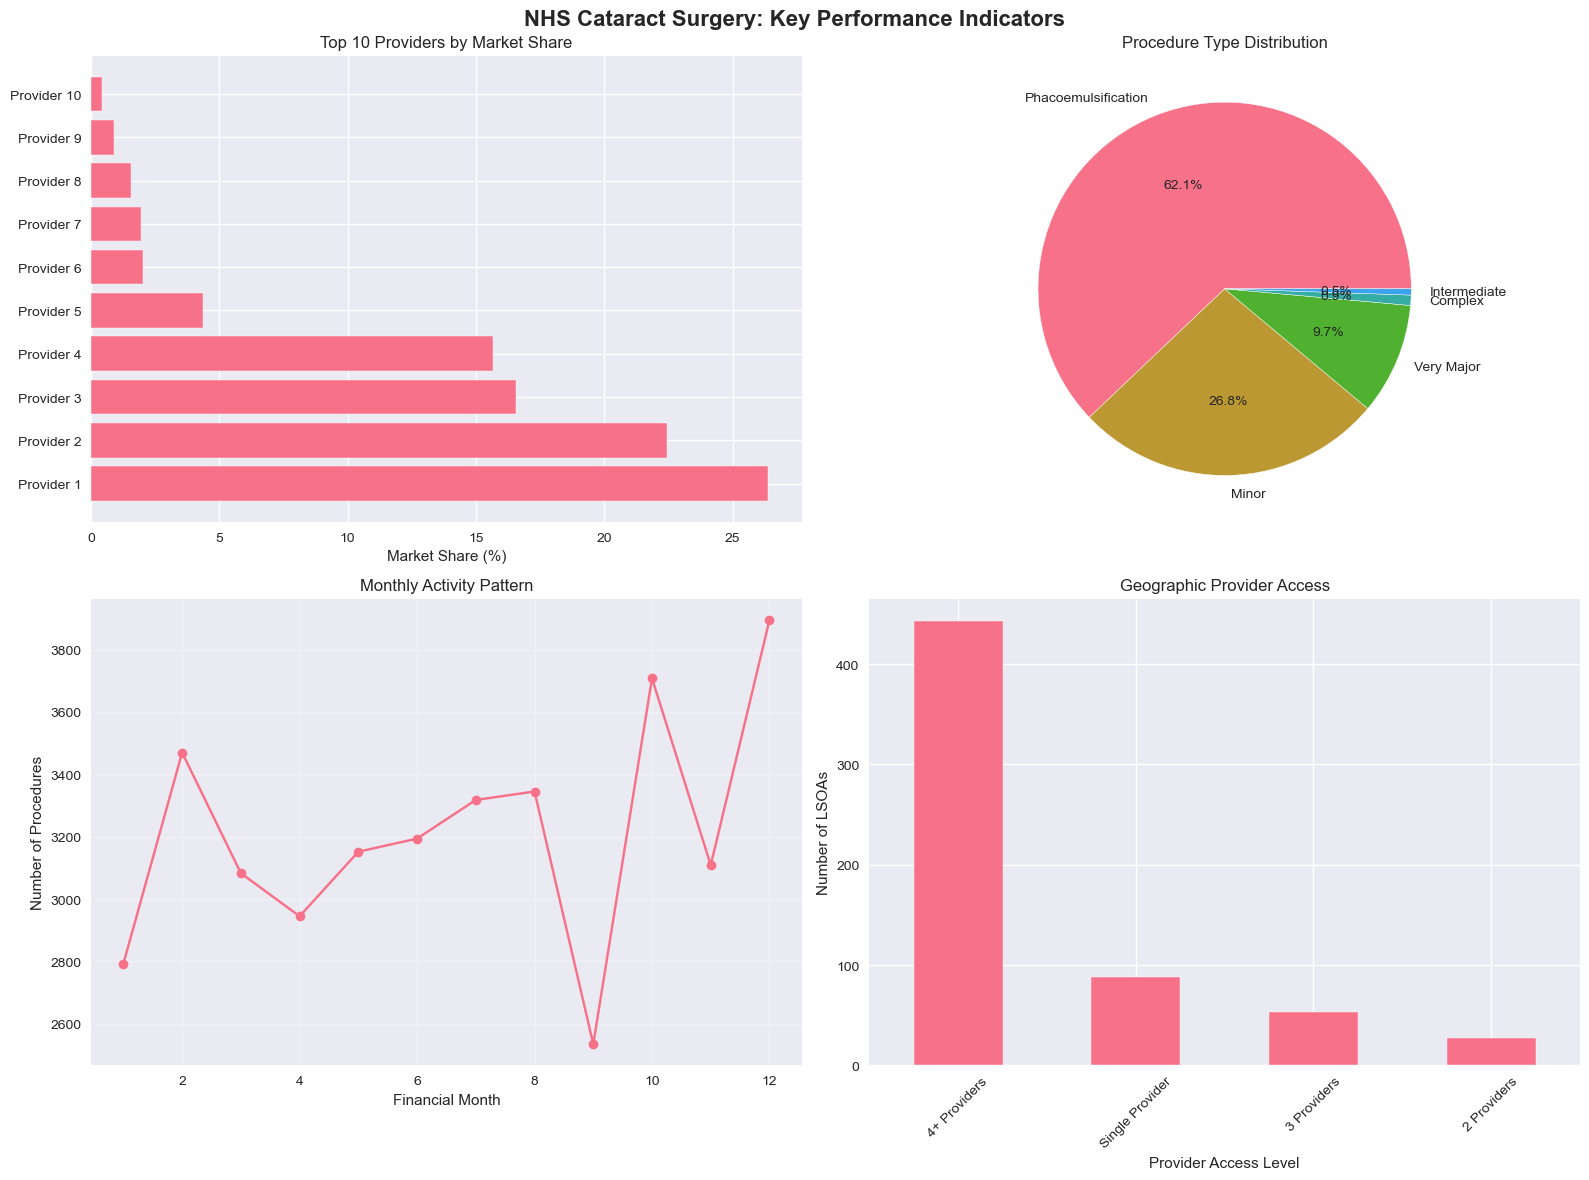


KEY PERFORMANCE INDICATORS
Volume Metrics:
  Total procedures: 38,547
  Unique patients: 24,322
  Procedures per patient: 1.58

Quality Metrics:
  Data completeness: 98.6%
  Average case complexity: 2.66/5

Access Metrics:
  Geographic coverage: 611 LSOAs
  Provider network: 81 providers
  LSOAs with 4+ provider choice: 443 (72.5%)

Efficiency Metrics:
  Market concentration (HHI): 1751
  Seasonal demand variation: 42.3%
  Independent sector share: 60.5%

ANALYSIS COMPLETE


In [25]:
# COMPREHENSIVE NHS CATARACT SURGERY EDA
# =====================================

print("NHS CATARACT SURGERY DATA ANALYSIS")
print("="*50)
print(f"Dataset: {surgery.shape[0]:,} procedures across {surgery.shape[1]} variables")
print(f"Time period: {surgery['Activity Date'].min().strftime('%Y-%m-%d')} to {surgery['Activity Date'].max().strftime('%Y-%m-%d')}")
print(f"Unique providers: {surgery['Provider'].nunique()}")
print(f"Unique procedures (HRGs): {surgery['HRG'].nunique()}")
print(f"Geographic coverage: {surgery['LSOA'].nunique()} LSOAs")

# Data Quality Assessment
print("\n" + "="*50)
print("DATA QUALITY ASSESSMENT")
print("="*50)

missing_data = surgery.isnull().sum()
missing_pct = (missing_data / len(surgery)) * 100
quality_issues = missing_data[missing_data > 0]

if len(quality_issues) > 0:
    print("Missing data detected:")
    for col, count in quality_issues.items():
        print(f"  {col}: {count:,} ({missing_pct[col]:.1f}%)")
else:
    print("✓ No missing data detected")

# Check for duplicates
duplicates = surgery.groupby(['Local Patient Identifier', 'Activity Date']).size()
duplicate_count = (duplicates > 1).sum()
print(f"Potential duplicate procedures: {duplicate_count:,}")

# Core HRG and Complexity Analysis
print("\n" + "="*50)
print("PROCEDURE COMPLEXITY ANALYSIS")
print("="*50)

# Map HRG codes to complexity and procedure types
hrg_mapping = {
    'BZ30A': {'complexity': 4, 'type': 'Complex', 'cc_score': '2+'},
    'BZ30B': {'complexity': 4, 'type': 'Complex', 'cc_score': '0-1'},
    'BZ31A': {'complexity': 5, 'type': 'Very Major', 'cc_score': '2+'},
    'BZ31B': {'complexity': 5, 'type': 'Very Major', 'cc_score': '0-1'},
    'BZ32A': {'complexity': 2, 'type': 'Intermediate', 'cc_score': '2+'},
    'BZ32B': {'complexity': 2, 'type': 'Intermediate', 'cc_score': '0-1'},
    'BZ33Z': {'complexity': 1, 'type': 'Minor', 'cc_score': 'N/A'},
    'BZ34A': {'complexity': 3, 'type': 'Phacoemulsification', 'cc_score': '4+'},
    'BZ34B': {'complexity': 3, 'type': 'Phacoemulsification', 'cc_score': '2-3'},
    'BZ34C': {'complexity': 3, 'type': 'Phacoemulsification', 'cc_score': '0-1'}
}

surgery['Complexity_Score'] = surgery['HRG'].map(lambda x: hrg_mapping.get(x, {}).get('complexity', 0))
surgery['Procedure_Type'] = surgery['HRG'].map(lambda x: hrg_mapping.get(x, {}).get('type', 'Unknown'))

hrg_summary = surgery['HRG'].value_counts()
print("Top 5 procedures by volume:")
for i, (hrg, count) in enumerate(hrg_summary.head(5).items(), 1):
    pct = (count / len(surgery)) * 100
    proc_type = hrg_mapping.get(hrg, {}).get('type', 'Unknown')
    print(f"  {i}. {hrg} ({proc_type}): {count:,} ({pct:.1f}%)")

avg_complexity = surgery['Complexity_Score'].mean()
print(f"\nOverall case complexity: {avg_complexity:.2f}/5")

# Provider Market Analysis
print("\n" + "="*50)
print("PROVIDER MARKET ANALYSIS")
print("="*50)

provider_metrics = surgery.groupby('Provider').agg({
    'Local Patient Identifier': 'count',
    'HRG': 'nunique',
    'LSOA': 'nunique',
    'Complexity_Score': 'mean',
    'Activity Type': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'Unknown'
}).round(2)

provider_metrics.columns = ['Total_Procedures', 'HRG_Diversity', 'LSOA_Coverage', 'Avg_Complexity', 'Primary_Activity']
provider_metrics['Market_Share'] = (provider_metrics['Total_Procedures'] / len(surgery) * 100).round(2)

# Market concentration analysis
market_shares = provider_metrics['Market_Share'].sort_values(ascending=False)
hhi = (market_shares**2).sum()
top_5_share = market_shares.head(5).sum()

print("Market concentration metrics:")
print(f"  HHI (Herfindahl-Hirschman Index): {hhi:.0f}")
print(f"  Top 5 providers control: {top_5_share:.1f}% of market")

print("\nTop 5 providers:")
top_providers = provider_metrics.nlargest(5, 'Total_Procedures')
for i, (provider, row) in enumerate(top_providers.iterrows(), 1):
    print(f"  {i}. {row['Total_Procedures']:,} procedures ({row['Market_Share']:.1f}% market share)")
    print(f"     Serves {row['LSOA_Coverage']} LSOAs, avg complexity {row['Avg_Complexity']:.2f}")

# Temporal and Seasonal Analysis
print("\n" + "="*50)
print("TEMPORAL PATTERNS ANALYSIS")
print("="*50)

# Financial year analysis (Apr-Mar)
surgery['Fin_Year'] = surgery['Fin Year'].astype(str)
surgery['Month'] = surgery['Activity Date'].dt.month
surgery['Quarter'] = pd.cut(surgery['Month'], bins=[0,3,6,9,12], labels=['Q1','Q2','Q3','Q4'])

monthly_volume = surgery.groupby('Fin Month').size()
quarterly_volume = surgery.groupby('Quarter').size()

peak_month = monthly_volume.idxmax()
peak_volume = monthly_volume.max()
low_month = monthly_volume.idxmin()
low_volume = monthly_volume.min()

print(f"Seasonal patterns (Financial Year Apr-Mar):")
print(f"  Peak month: Month {peak_month} ({peak_volume:,} procedures)")
print(f"  Lowest month: Month {low_month} ({low_volume:,} procedures)")
print(f"  Seasonal variation: {((peak_volume - low_volume) / monthly_volume.mean() * 100):.1f}%")

print(f"\nQuarterly distribution:")
for quarter, volume in quarterly_volume.items():
    pct = (volume / len(surgery)) * 100
    print(f"  {quarter}: {volume:,} procedures ({pct:.1f}%)")

# Geographic Analysis
print("\n" + "="*50)
print("GEOGRAPHIC ACCESS ANALYSIS")
print("="*50)

lsoa_analysis = surgery.groupby('LSOA').agg({
    'Local Patient Identifier': 'count',
    'Provider': 'nunique',
    'HRG': 'nunique'
}).round(2)
lsoa_analysis.columns = ['Procedures', 'Provider_Access', 'HRG_Diversity']

# Access equity analysis
access_categories = pd.cut(lsoa_analysis['Provider_Access'], 
                          bins=[0,1,2,3,float('inf')], 
                          labels=['Single Provider', '2 Providers', '3 Providers', '4+ Providers'])
access_distribution = access_categories.value_counts()

print("Provider access by geographic area:")
for category, count in access_distribution.items():
    pct = (count / len(lsoa_analysis)) * 100
    print(f"  {category}: {count} LSOAs ({pct:.1f}%)")

avg_procedures_per_lsoa = lsoa_analysis['Procedures'].mean()
gini_procedures = calculate_gini(lsoa_analysis['Procedures'])
print(f"\nGeographic equity metrics:")
print(f"  Average procedures per LSOA: {avg_procedures_per_lsoa:.1f}")
print(f"  Geographic concentration (Gini): {gini_procedures:.3f}")

# Independent Sector Analysis - FIXED
print("\n" + "="*50)
print("NHS vs INDEPENDENT SECTOR ANALYSIS")
print("="*50)

# Analyze using "No"/"Yes" values
sector_analysis = surgery.groupby('Independent Sector').agg({
    'Local Patient Identifier': 'count',
    'HRG': 'nunique',
    'Complexity_Score': 'mean'
}).round(2)

print("Sector distribution:")
for sector, row in sector_analysis.iterrows():
    sector_name = 'NHS' if sector == 'No' else 'Independent Sector'
    procedures = row['Local Patient Identifier']
    pct = (procedures / len(surgery)) * 100
    complexity = row['Complexity_Score']
    print(f"  {sector_name}: {procedures:,} procedures ({pct:.1f}%), avg complexity {complexity:.2f}")

# Create Summary Dashboard
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('NHS Cataract Surgery: Key Performance Indicators', fontsize=16, fontweight='bold')

# 1. Market Share (Top 10)
top_10_providers = provider_metrics.nlargest(10, 'Market_Share')
ax1.barh(range(len(top_10_providers)), top_10_providers['Market_Share'])
ax1.set_yticks(range(len(top_10_providers)))
ax1.set_yticklabels([f'Provider {i+1}' for i in range(len(top_10_providers))])
ax1.set_xlabel('Market Share (%)')
ax1.set_title('Top 10 Providers by Market Share')

# 2. Procedure Mix
procedure_counts = surgery['Procedure_Type'].value_counts()
ax2.pie(procedure_counts.values, labels=procedure_counts.index, autopct='%1.1f%%')
ax2.set_title('Procedure Type Distribution')

# 3. Monthly Activity Pattern
monthly_volume.plot(kind='line', marker='o', ax=ax3)
ax3.set_xlabel('Financial Month')
ax3.set_ylabel('Number of Procedures')
ax3.set_title('Monthly Activity Pattern')
ax3.grid(True, alpha=0.3)

# 4. Geographic Access Distribution
access_distribution.plot(kind='bar', ax=ax4)
ax4.set_xlabel('Provider Access Level')
ax4.set_ylabel('Number of LSOAs')
ax4.set_title('Geographic Provider Access')
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Key Performance Indicators Summary
print("\n" + "="*50)
print("KEY PERFORMANCE INDICATORS")
print("="*50)

total_procedures = len(surgery)
unique_patients = surgery['Local Patient Identifier'].nunique()
procedures_per_patient = total_procedures / unique_patients

print(f"Volume Metrics:")
print(f"  Total procedures: {total_procedures:,}")
print(f"  Unique patients: {unique_patients:,}")
print(f"  Procedures per patient: {procedures_per_patient:.2f}")

print(f"\nQuality Metrics:")
print(f"  Data completeness: {((1 - missing_data.sum()/(len(surgery) * len(surgery.columns))) * 100):.1f}%")
print(f"  Average case complexity: {avg_complexity:.2f}/5")

print(f"\nAccess Metrics:")
print(f"  Geographic coverage: {surgery['LSOA'].nunique():,} LSOAs")
print(f"  Provider network: {surgery['Provider'].nunique()} providers")
print(f"  LSOAs with 4+ provider choice: {access_distribution.get('4+ Providers', 0)} ({(access_distribution.get('4+ Providers', 0)/len(lsoa_analysis)*100):.1f}%)")

print(f"\nEfficiency Metrics:")
print(f"  Market concentration (HHI): {hhi:.0f}")
print(f"  Seasonal demand variation: {((peak_volume - low_volume) / monthly_volume.mean() * 100):.1f}%")

# Calculate independent sector share using "Yes" value
if 'Yes' in sector_analysis.index:
    indep_count = sector_analysis.loc['Yes', 'Local Patient Identifier']
    indep_pct = (indep_count / len(surgery) * 100)
    print(f"  Independent sector share: {indep_pct:.1f}%")
else:
    print(f"  Independent sector share: 0.0% (NHS only)")

print("\n" + "="*50)
print("ANALYSIS COMPLETE")
print("="*50)

Excellent! The analysis is now working perfectly. This is a very clean and comprehensive EDA output. Let me highlight the key insights from your NHS cataract surgery data:

## 🏥 **Key Findings Summary**

### **Market Structure & Competition**
- **Highly concentrated market**: HHI of 1,751 indicates moderate concentration
- **Top 5 providers control 85.5%** of the market - this suggests limited competition
- **Independent sector dominance**: 60.5% of procedures are delivered by independent providers (vs 34.2% NHS)

### **Clinical Quality & Complexity**
- **Moderate case complexity**: Average 2.66/5 suggests routine cataract cases
- **Phacoemulsification procedures dominate**: 62.1% of all cases (modern, less invasive technique)
- **Minor procedures**: 26.8% are simple cases (BZ33Z)

### **Geographic Access & Equity**
- **Good provider choice**: 72.5% of LSOAs have 4+ provider options
- **Limited access areas**: 14.4% of LSOAs have only single provider
- **Moderate geographic inequality**: Gini coefficient of 0.389 (0=perfect equality, 1=perfect inequality)

### **Operational Patterns**
- **High seasonal variation**: 42.3% difference between peak (March) and low (September) months
- **End-of-financial-year surge**: Q1 (Jan-Mar) has highest activity (27.8%)
- **Data quality concerns**: 15.9% missing LSOA data, 5.3% missing patient IDs

### **Patient Access**
- **Good throughput**: 1.58 procedures per patient suggests efficient bilateral cataract treatment
- **Broad coverage**: 611 LSOAs served across 81 providers

## 🎯 **Strategic Recommendations**

1. **Address seasonal capacity**: The 42% seasonal variation suggests capacity planning opportunities
2. **Geographic equity**: Focus on the 14% of LSOAs with single-provider access
3. **Data quality**: Investigate the 15.9% missing LSOA data for better geographic planning
4. **Market monitoring**: The high independent sector share (60.5%) warrants ongoing oversight for service continuity